In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time as ti
%matplotlib inline

#### Question 1

In [2]:
def voltage_diff(voltage, args_v):
    leak_potential  = args_v['leak_potential']
    memb_resistance = args_v['membrane_resistance']
    tau_m           = args_v['tau_m']
    synapse_current = args_v['synapse_current']

    return (leak_potential - voltage + memb_resistance * synapse_current) / tau_m

In [3]:
def synapse_spike_chances(synapses_count):
    return np.array([random.uniform(0,1) for i in range(synapses_count)])

In [4]:
def q1_real(args_v, args_s, v_reset, v_threshold, synapses, time=1000, step=0.25):
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']

    time_range = np.linspace(0, time, int(time / step))

    volts = []
    spikes_count = 0
    v = v_reset
    
    s_vec = np.full(synapses, peak_conductance, dtype=float)
    peak_vec = np.full(synapses, peak_conductance, dtype=float)

    for time in time_range:
        synapse_spikes = synapse_spike_chances(synapses)
        for i, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[i] += delta_s
            else:
                s_vec[i] = s_vec[i] - (s_vec[i] * step) / tau_s

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        
        if (v > v_threshold):
            spikes_count += 1
            v = v_reset
        volts.append(v)
        
    return time_range, volts, spikes_count

In [5]:
args_v1 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10                 # Membrane time constant (ms)
}
v_reset = -65
v_threshold = -50

args_s1 = {
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

synapses_count = 40
time, volts, spikes_count = q1_real(args_v1, args_s1, v_reset, v_threshold, synapses_count)
print("spikes_count:", spikes_count)

spikes_count: 18


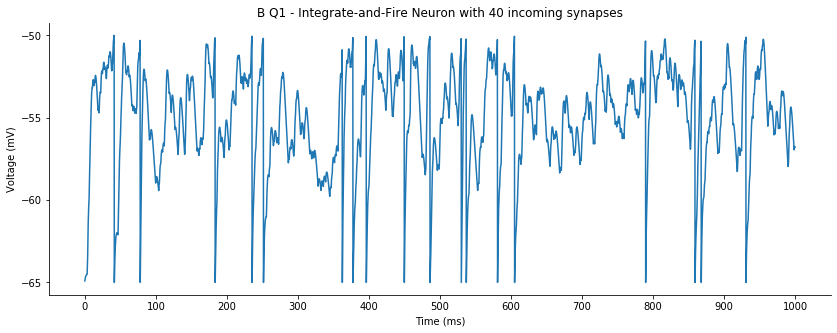

In [6]:
def plot_q1(title, filename, time, volts):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.plot(time, volts)
    ax.set_yticks(range(-65,-45,5))
    ax.set_xticks(range(0,1001,100))
#     fig.savefig(f"plots/{filename}.png", bbox_inches='tight', pad_inches=0.2, dpi=100)

title = "B Q1 - Integrate-and-Fire Neuron with 40 incoming synapses"
plot_q1(title, 'b_q1', time, volts)

#### Question 2
Pre-before-post causes LT-Potentiation

Post-before-pre cuases LT-Depression

In [7]:
def conductance_diff(args_stdp, delta_t):
    a_plus      = args_stdp['a_plus']
    a_minus     = args_stdp['a_minus']
    tau_plus    = args_stdp['tau_plus']
    tau_minus   = args_stdp['tau_minus']
    if delta_t > 0:
        return a_plus * np.exp(-delta_t / tau_plus)
    else:
        return - a_minus * np.exp(delta_t / tau_minus)   

In [8]:
def sanitize_conductance(conductance, peak):
    if conductance > peak:
        return peak
    elif  conductance < 0:
        return 0
    else:
        return conductance

In [9]:
def update_conductance(args_stdp, peak_vec, index, delta_t, peak):
    delta_peak = conductance_diff(args_stdp, delta_t)
    peak_vec[index] = sanitize_conductance(peak_vec[index] + delta_peak,
                                           peak)
#     print(f"delta:{delta_peak}", f"-> {round(peak_vec[index],4)}")

In [10]:
def q2_stdp(args_v, args_s, args_stdp, time=1000, step=0.25):
    v_reset                 = args_v['v_reset']
    v_threshold             = args_v['v_threshold']
    
    synapses_count          = args_s['synapses_count']
    reversal_potential      = args_s['reversal_potential']
    peak_conductance        = args_s['g_bar']
    delta_s                 = args_s['delta_s']
    tau_s                   = args_s['tau_s']
    firing_rate             = args_s['firing_rate']
    
    stdp                    = args_stdp['enabled']

    time_range = np.linspace(0, time, int(time / step))

    volts = []
    v     = v_reset
    
    s_vec    = np.full(synapses_count, peak_conductance, dtype=float)
    peak_vec = np.full(synapses_count, peak_conductance, dtype=float)
    
    t_pre  = np.full(synapses_count, -1, dtype=float)
    t_post = -1

    for time in time_range:
        
        synapse_spikes = synapse_spike_chances(synapses_count)
        for j, chance in enumerate(synapse_spikes):
            if chance < firing_rate * step:
                s_vec[j] += delta_s
                if stdp:
                    t_pre[j] = time
#                     print(f"Pre {int(time)}ms", f"s{j}", f"dt{int(t_post - t_pre[j])}", end=" ")
                    update_conductance(args_stdp, peak_vec, j, t_post - t_pre[j], peak_conductance)

            else:
                s_vec[j] = s_vec[j] - (s_vec[j] * step) / tau_s 

        args_v['synapse_current'] = np.sum(s_vec * peak_vec) * (reversal_potential - v)

        v = v + step * voltage_diff(v, args_v)
        volts.append(v)
        
        if (v > v_threshold):
            v = v_reset
            if stdp:
                t_post = time
                for j in range(synapses_count):
#                     print(f"Post {int(time)}ms", f"s{j}", f"dt{int(t_post - t_pre[j])}", end=" ")
                    update_conductance(args_stdp, peak_vec, j, t_post - t_pre[j], peak_conductance)
        
    return time_range, volts, peak_vec

#### STDP ON

In [11]:
conductances_collection = []

In [12]:
args_v2 = {
    'leak_potential': -65,      # E_L (mV)
    'membrane_resistance': 100, # R_m (mV/nA)
    'tau_m': 10,                # Membrane time constant (ms)
    'v_reset': -65,             # (mV)
    'v_threshold': -50          # (mV)
}

args_s2 = {
    'synapses_count': 40,         # N
    'reversal_potential': 0,      # E_s (mV)
    'g_bar': 0.004,               # Peak conductance (nA/mV)
    'delta_s': 0.5,               # Conductance gate jump
    'tau_s': 2,                   # Membrane time constant (ms)
    'firing_rate': 0.015          # Spike Frequency (spikes/ms)
}

args_stdp = {
    'enabled':   True,        # "ON"
    'a_plus':    0.0002,      # (nA/mV)
    'a_minus':   0.00025,     # (nA/mV)
    'tau_plus':  20,          # (ms)
    'tau_minus': 20           # (ms)
}

In [13]:
seconds = 300
trails = 1
print(f"Simulating {trails} trail(s) of {seconds} seconds each ...")
for trail in range(trails):
    print(f"Trail {trail+1}")
    time_range, volts2, conductances = q2_stdp(args_v2, args_s2, args_stdp, time=seconds*1000)
    conductances_collection.append(conductances)

Simulating 1 trail(s) of 300 seconds each ...
Trail 1


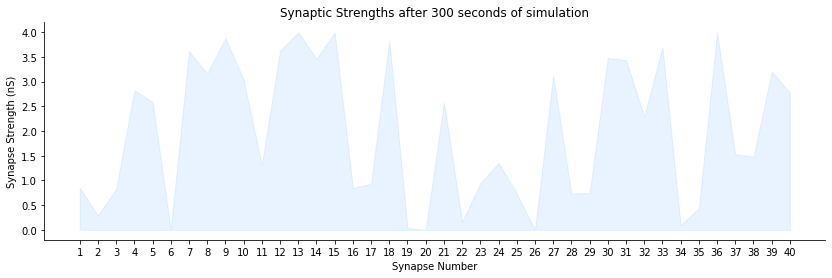

In [14]:
def plot_q2_synapse(title, filename, time_range, collection):
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel("Synapse Number")
    ax.set_ylabel("Synapse Strength (nS)")
    
    x = range(1,41)
    for conductances in collection:
        y = conductances * 1000
        ax.fill_between(x, y, color='dodgerblue', alpha=0.1)
    ax.set_xticks(x)
    fig.savefig(f"plots/{filename}-{int(ti.time())}.png", dpi=100,
                bbox_inches='tight', pad_inches=0.2
               )
title = "Synaptic Strengths after 300 seconds of simulation"
plot_q2_synapse(title, "b_q2_strenghts", time_range, conductances_collection)

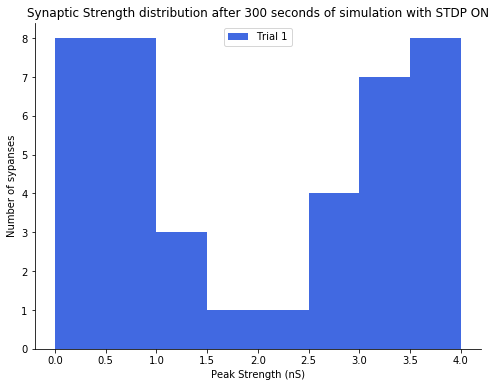

In [15]:
def plot_q2_dist(title, filename, time_range, cond_collection, x_ticks=True):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot()
    ax.set_title(title)
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.set_xlabel("Peak Strength (nS)"); ax.set_ylabel("Number of sypanses")

    x = (np.array(cond_collection) * 1000).T
    n_bins = 8
    trails = x.shape[1]
    colors = ["royalblue", "dodgerblue", "deepskyblue", "darkturquoise", "aquamarine"]
    labels = [f"Trial {i+1}" for i in range(trails)]
    ax.hist(x, bins=n_bins, color=colors[:trails], label=labels[:trails])
    ax.legend(prop={'size': 10})
    if x_ticks: ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
    fig.savefig(f"plots/{filename}.png", dpi=100, bbox_inches='tight', pad_inches=0.2)

title = "Synaptic Strength distribution after 300 seconds of simulation with STDP ON"
plot_q2_dist(title, f"b_q2_hist_stdp_on_{int(ti.time())}", time_range, conductances_collection)

In [16]:
def firing_rates(volts, v_th):
    y = np.array(volts).reshape(30,40000)
    avg_fire_rates = ((y >= v_th).sum(axis=1)) /10
    return avg_fire_rates

avg_firing_rates = firing_rates(volts2, args_v2["v_threshold"])
avg_firing_rates

array([6.1, 1.7, 0.8, 1.1, 0.1, 0.6, 0.4, 0.4, 0.2, 0.1, 0.2, 0.1, 0.3,
       0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.2, 0. , 0.2, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.2, 0.1, 0.2])

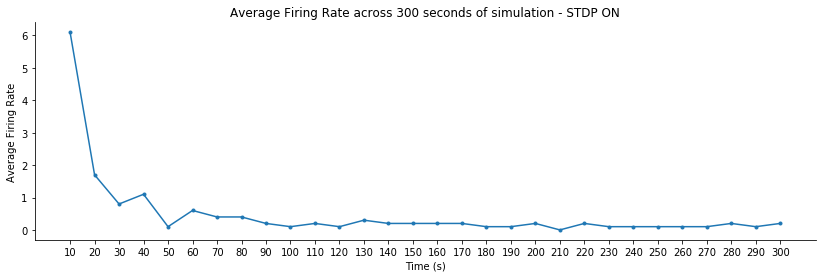

In [17]:
def plot_q2_firing_rate(title, filename, time_range, averages):
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot()
    ax.set_title(title)
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Average Firing Rate")

#     trails = 1
#     colors = ["royalblue", "dodgerblue", "deepskyblue", "darkturquoise", "aquamarine"]
#     labels = [f"Trial {i+1}" for i in range(trails)]
    ax.plot(range(10,310,10), averages, marker='.')#, color=colors, label=labels[:trails])
    ax.set_xticks(range(10,310,10))
    ax.set_yticks(range(0,int(max(averages)+1)))
    fig.savefig(f"plots/{filename}.png", dpi=100,bbox_inches='tight', pad_inches=0.2)

title = "Average Firing Rate across 300 seconds of simulation - STDP ON"
plot_q2_firing_rate(title, f"b_q2_frate_stdp_on_{int(ti.time())}",
             time_range, avg_firing_rates)

In [18]:
len(volts2)

1200000

#### STDP OFF

In [19]:
args_stdp['enabled'] = False
seconds = 300
trails = 1
conductances_collection = []
print(f"Simulating {trails} trail(s) of {seconds} seconds each ...")
for trail in range(trails):
    print(f"Trail {trail}")
    time_range, volts2, conductances = q2_stdp(args_v2, args_s2, args_stdp, time=seconds*1000)
    conductances_collection.append(conductances)

Simulating 1 trail(s) of 300 seconds each ...
Trail 0


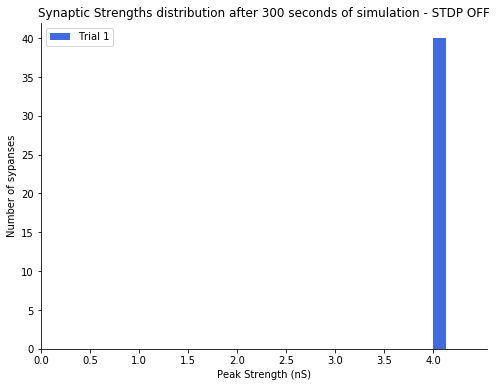

In [20]:
title = "Synaptic Strengths distribution after 300 seconds of simulation - STDP OFF"
plot_q2_dist(title, f"b_q2_hist_stdp_off_{int(ti.time())}", time_range, conductances_collection)

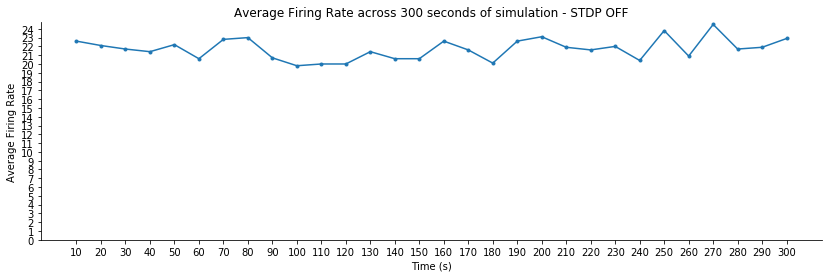

In [21]:
avg_firing_rates = firing_rates(volts2, args_v2["v_threshold"])
avg_firing_rates

title = "Average Firing Rate across 300 seconds of simulation - STDP OFF"
plot_q2_firing_rate(title, f"b_q2_frate_stdp_off_{int(ti.time())}",
             time_range, avg_firing_rates)